In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import h5py
from umda.smi_vec import inchi_to_smiles, load_model, smi_to_vector
# import umap.plot
from umap import UMAP

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

plt.style.use("publication")

Traceback (most recent call last):
  File "/home/kelvin/anaconda3/envs/rdkit/lib/python3.6/site-packages/rdkit/Chem/PandasTools.py", line 130, in <module>
    if 'display.width' in pd.core.config._registered_options:
AttributeError: module 'pandas.core' has no attribute 'config'


In [2]:
data = h5py.File("../../data/processed/smiles_embeddings_300.h5", "r")

In [3]:
data.keys()

<KeysViewHDF5 ['cluster_ids', 'pca', 'smiles', 'vectors']>

In [4]:
manifold_model = UMAP(n_neighbors=20, n_components=2, random_state=42, metric="cosine")

In [5]:
indices = np.arange(len(data["vectors"]))

rng = np.random.default_rng(42)

chosen = rng.choice(indices, 100000, replace=False)
chosen.sort()

In [6]:
# loading data in a non-contiguous way takes a damn long time
vectors = data["vectors"][:,:]

In [7]:
manifold_model.fit(vectors[chosen])

UMAP(angular_rp_forest=True, metric='cosine', n_neighbors=20, random_state=42)

In [8]:
tmc1_df = pd.read_pickle("../../data/interim/tmc1_table_vecs.pkl")

tmc1_vecs = np.vstack(tmc1_df["Vecs"])

In [9]:
tmc1_embedding = manifold_model.transform(tmc1_vecs)

## Get KIDA embeddings

In [10]:
kida_df = pd.read_csv("../../data/external/kida-molecules_05_Jul_2020.csv")

In [11]:
kida_smi = kida_df["InChI"].apply(inchi_to_smiles).to_list()

In [12]:
kida_smi = [smi for smi in kida_smi if smi]

In [13]:
m2v_model = load_model("../../models/mol2vec_model.pkl")

In [14]:
kida_vectors = list()
for smi in kida_smi:
    try:
        vec = smi_to_vector(smi, m2v_model)
        if vec.sum() != 0.:
            kida_vectors.append(vec)
    except:
        pass

In [15]:
kida_vectors = np.vstack(kida_vectors)

kida_embedding = manifold_model.transform(kida_vectors)

In [16]:
kida_embedding[456]

array([16.443647, 12.782227], dtype=float32)

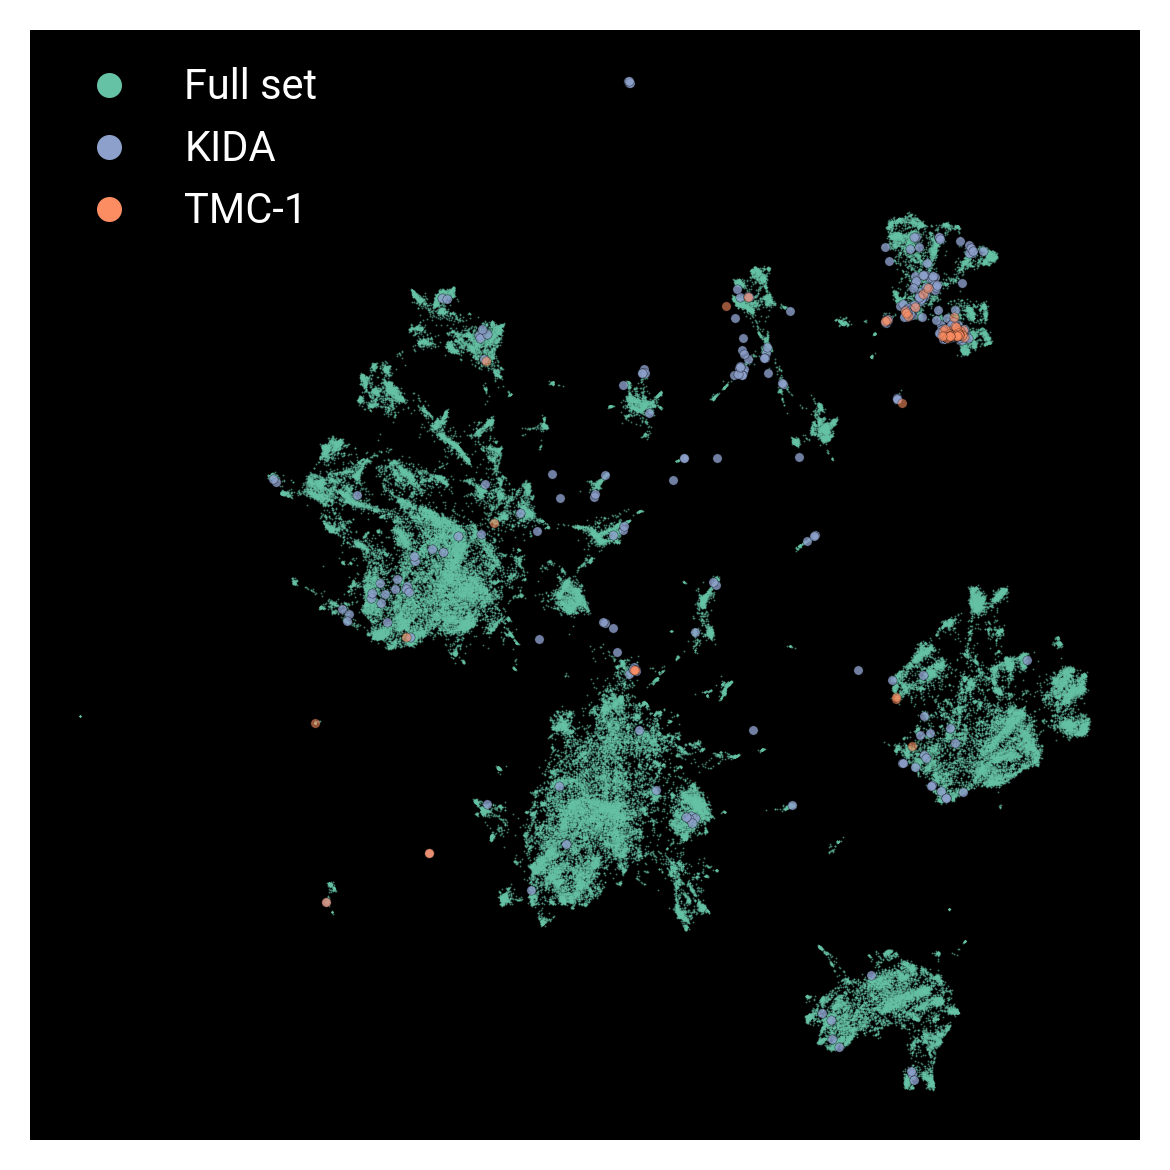

In [20]:
fig, ax = plt.subplots(figsize=(4,4))

ax.scatter(manifold_model.embedding_[:,0], manifold_model.embedding_[:,1], s=0.2, alpha=0.6, lw=0., color="#66c2a5")
ax.scatter(kida_embedding[:,0], kida_embedding[:,1], s=5, alpha=0.8, lw=0.1, color="#8da0cb", edgecolors="k", label="KIDA")
ax.scatter(tmc1_embedding[:,0], tmc1_embedding[:,1], s=5, alpha=0.6, lw=0.1, color="#fc8d62", edgecolors="k", label="TMC-1")
ax.set(xticks=[], yticks=[])
ax.set_facecolor("k")
handles = [
    Line2D([0], [0], color="#66c2a5", label="Full set", lw=0., marker='o'),
    Line2D([0], [0], color="#8da0cb", label="KIDA", lw=0., marker='o'),
    Line2D([0], [0], color="#fc8d62", label="TMC-1", lw=0., marker='o')
]
legend = ax.legend(handles=handles)
for text in legend.get_texts():
    plt.setp(text, color = 'w')
for spine in ax.spines.values():
    spine.set_visible(False)

fig.savefig("umap_all_mols.pdf", dpi=100)